## 0. Описание

Представим, что мы снова являемся аналитиками в маленькой инди-студии разработки игр **<em>HuracanoGames</em>**. Мы прекрасно понимаем, что важно сделать качественно не только игру, но и её страницу в магазине, в котором она будет продаваться. Поскольку игра планирует запускаться в [Steam](https://store.steampowered.com/), хотелось бы понять настроения юзеров данной платформы и по имеющимся уже описанием игр составить классификатор, который определил бы, хорошо составлено описание новой игры.

## 1. Получение данных

##### Библиотеки

In [3]:
# System / utils
import os
import sys
import shutil
import gc
from multiprocessing.dummy import Pool as ThreadPool
from threading import Lock

from IPython.display import clear_output
from tqdm import tqdm

# Data retrieve 
from bs4 import BeautifulSoup
import requests
import re

# Data processing
from glob import glob
import json
import nltk
from nltk.corpus import stopwords, wordnet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import datetime

# ML/DL
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA

import torch
from torchmetrics import ConfusionMatrix


/home/wrongwizzli/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/wrongwizzli/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
device

'cuda'

In [3]:
config = json.load(open("config.json", "r"))

In [4]:
# nltk.download('stopwords')
# nltk.download("wordnet")
# nltk.download("wordnet2021")
# nltk.download("omw-1.4")

##### Вытащим данные при помощи запросов по URL

In [5]:
# Utility block. Multiple request to the given url
lock = Lock()
def multi_request(path, repeats=5, headers=None):
    for i in range(repeats):
        if headers is not None:
            req = requests.get(path, headers=headers, stream=True)
        else:
            req = requests.get(path)
        if req.status_code // 100 == 2:
            break
    if req.status_code // 100 != 2:
        return None
    return req

In [6]:
# Parse html page of single game on Steam
def page_parser(ans):
    soup = BeautifulSoup(ans.text, 'html.parser')
    game_info = {
        'url': ans.url,
    }
    
    # Title
    name = soup.find('div', id="appHubAppName", class_="apphub_AppName")
    if name is not None:
        game_info['name'] = name.text
        
    # Review status
    review = soup.find('div', class_="user_reviews_summary_row", itemprop="aggregateRating")
    if review is not None:
        review_score = review.find('span', class_="nonresponsive_hidden responsive_reviewdesc")
        if review_score is not None:
            scores = re.findall('(\d+)%', review_score.text.strip())
            if len(scores) > 0:
                game_info['score_review'] = scores[0]
        review_count = review.find('meta', itemprop='reviewCount')
        if review_count is not None and review_count.has_attr('content'):
            game_info['vote_number'] = review_count['content']
        review_steam_rating = review.find('meta', itemprop='ratingValue')
        if review_steam_rating is not None and review_steam_rating.has_attr('content'):
            game_info['steam_rating'] = review_steam_rating['content']

    # User tags
    user_tags = soup.find('div', class_="glance_tags_ctn popular_tags_ctn")
    if user_tags is not None:
        user_tags = user_tags.find_all('a', class_='app_tag')
        game_info['user_tags'] = [tag.text.strip() for tag in user_tags]

    # Developers
    developers = soup.find('div', id="developers_list")
    if developers is not None:
        developers = developers.find_all('a')
        game_info['developers'] = [dev.text.strip() for dev in developers]

    # Is DLC
    dlc_info = soup.find("div", class_="game_area_bubble game_area_dlc_bubble")
    game_info['is_dlc'] = dlc_info is not None

    # Release date
    date = soup.find('div', class_="release_date")
    if date is not None:
        date = date.find('div', class_="date")
        if date is not None:
            game_info['release_date'] = date.text.strip()

    # Developers labels
    dev_labels = soup.find('div', class_="block responsive_apppage_details_left")
    if dev_labels is not None:
        labels = dev_labels.find_all('div', class_='label')
        game_info['dev_tags'] = [label.text.strip() for label in labels]

    # Developers genres
    dev_genres = soup.find('div', id="genresAndManufacturer")
    if dev_genres is not None:
        dev_genres = dev_genres.find('span', {"data-panel": '{"flow-children":"row"}'})
        if dev_genres is not None:
            genres = dev_genres.find_all('a')
            game_info['dev_genres'] = [dev_genre.text for dev_genre in genres]
    
    # Languages
    languages = soup.find('div', class_="block responsive_apppage_details_right")
    if languages is not None:
        languages = languages.find_all('td', class_="ellipsis")
        game_info['languages'] = [language.text.strip() for language in languages]
    
    # Price
    price = soup.find("div", class_="discount_original_price")
    if price is None:
        price = soup.find("div", class_="game_purchase_price price")
    if price is not None:
        price = price.text.strip()
        re_price = re.search("\d+", price)
        if re_price is not None:
            game_info['price'] = re_price.group(0)
        elif "free" in price.lower():
            game_info['price'] = "0"
            
    
    # Game information
    game_info['description'] = ''
    description = soup.find('div', id='game_area_description')
    if description is not None:
        clean_description = re.sub('<.*?>', '', description.text)
        clean_text = re.sub('\s+', ' ', clean_description).strip()
        game_info['description'] = clean_text
    
    save_name = game_info['name'].replace(' ', '_').replace('/','_')
    
    # Header image
    header_image = soup.find('img', class_='game_header_image_full')
    if header_image is not None:
        img_url = header_image['src']
        image_ans = multi_request(img_url)
        if image_ans is not None:
            with open(f"header_images/{save_name}.jpg", "wb") as f:
                f.write(image_ans.content)
        
    # First game screenshot image
    first_screenshot_image = soup.find('div', id='highlight_strip_scroll')
    if first_screenshot_image is not None:
        image = first_screenshot_image.find_next('div', class_='highlight_strip_item highlight_strip_screenshot')
        if image is not None:
            image = image.find("img")
            if image is not None:
                image_url = image['src']
                image_url = image_url.replace("116x65", "600x338")
                image_ans = multi_request(image_url)
                if image_ans is not None:
                    with open(f"first_screens/{save_name}.jpg", "wb") as f:
                        f.write(image_ans.content)
        
    return game_info

In [7]:
# Get urls of 6000 latest rogue-likes
urls = []
# for i in tqdm(range(0, 6000, 100)):
#     ans = multi_request(f"https://store.steampowered.com/search/results/?query&start={i}&count={i+100}&dynamic_data=&sort_by=Released_DESC&tags=42804&snr=1_7_7_240_7&infinite=1")
#     answer = re.sub(r'\\', '', ans.text)
#     urls += re.findall('"(https://store.steampowered.com/app.+?)"', answer)

In [8]:
# Utility function that requests for Steam page and saves the result of processing
def proceed_page(url):
    # if url is None:
    #     with lock:
    #         print('Url is incorrect', file=sys.stderr)
    #     return None
    # ans = multi_request(url)
    # if ans is None:
    #     with lock:
    #         print(f'Page cannot be reached with web-address: {url}')
    #     return None
    # page = page_parser(ans)
    
    # # require './jsons_roguelikes' folder. Uncomment if you have one and need to save .json files
    # try:
    #     with open('./jsons_roguelikes/' + page['name'].replace(' ', '_').replace('/','_') + '.json', 'w') as out:
    #         json.dump(page, out, indent=1)
    # except Exception as e:
    #     pass
    # return page
    pass

with ThreadPool(10) as pool:
    pages = pool.map(proceed_page, urls)

## 2. Проверка полученных данных

##### Посчитаем кол-во извлеченных полей

In [9]:
json_file_names = sorted(glob("jsons_roguelikes/*"))
len(json_file_names)

1737

In [10]:
result = {}
for jname in tqdm(json_file_names):
    game_data = json.load(open(jname, "r"))
    for key in game_data.keys():
        if key not in result:
            result[key] = 0
        if key == "score_review" and "vote_number" in game_data:
            if int(game_data[key]) >= 84:
                if "high_scored" not in result:
                    result["high_scored"] = 0
                result["high_scored"] += 1
            else:
                if "low_scored" not in result:
                    result["low_scored"] = 0
                result["low_scored"] += 1
        result[key] += 1
result

100%|██████████| 1737/1737 [00:00<00:00, 5021.90it/s]


{'url': 1737,
 'name': 1737,
 'score_review': 953,
 'low_scored': 465,
 'vote_number': 1440,
 'steam_rating': 1440,
 'user_tags': 1737,
 'developers': 1735,
 'is_dlc': 1737,
 'release_date': 1735,
 'dev_tags': 1737,
 'dev_genres': 1734,
 'languages': 1734,
 'price': 1542,
 'description': 1737,
 'high_scored': 488}

##### Визуализируем распределение отзывов

In [11]:
json_file_names = sorted(glob("jsons_roguelikes/*"))

In [12]:
# Show median of score reviews
reviews = []
for jname in tqdm(json_file_names):
    game_data = json.load(open(jname, "r"))
    if 'score_review' in game_data.keys():
        reviews.append(int(game_data["score_review"]))

100%|██████████| 1737/1737 [00:00<00:00, 31396.28it/s]


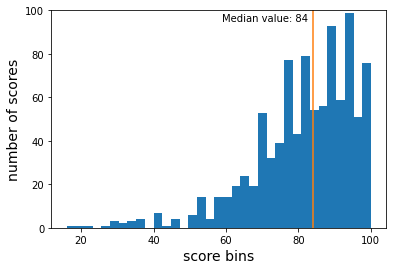

In [13]:
# Build plot
plt.hist(reviews, bins=35)
plt.plot([np.median(reviews), np.median(reviews)], [0, 100])
plt.text(np.median(reviews) - 25, 95, f"Median value: {int(np.median(reviews))}")
plt.ylim(0, 100)
plt.ylabel("number of scores", fontsize=14)
plt.xlabel("score bins", fontsize=14)
plt.savefig("score_review_distribution.png", dpi=200, bbox_inches='tight')

##### Визуализируем пропущенные значения по датам

Будем рассматривать только поля `score_review` и `vote_number`. `steam_rating` существует тогда, когда существует `vote_number`, поэтому их распределение будет одинаковым. Остальные поля же не пусты от слова совсем (кроме выбросов)

In [14]:
# Utility date parser block
# 🌠 and 🦇 and even more strange dates inside, so date parser is not so trivial
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']


def parse_quarter(str_date: str):
    quarter = re.search('q\d', str_date)
    if quarter is None:
        return str_date
    q_number = int(str_date[quarter.end() - 1])
    q_month = "feb"
    if q_number == 2:
        q_month = "may"
    if q_number == 3:
        q_month = "aug"
    if q_number == 4:
        q_month = "nov"
    return re.sub('q\d', q_month, str_date)


def try_fit_formats(str_date: str):
    for fmt in ("%d %b, %Y", "%b %Y", "%B %Y", "%Y"):
        try:
            formatted_date = datetime.datetime.strptime(str_date, fmt)
            return formatted_date.date()
        except ValueError as err:
            continue
    return None


def clean_str_date(str_date: str):
    year = None
    re_year = re.search("\d\d\d\d", str_date)
    if re_year is not None:
        year = str_date[re_year.start():re_year.end()]
    if year is None:
        return str_date

    month = "jan"
    for mon in months:
        if mon in str_date:
            month = mon
            break
    return " ".join([month, year]) 
    

def format_date(str_date: str):
    str_date = parse_quarter(str_date.lower())
    
    date = try_fit_formats(str_date)
    if date is not None:
        return date
    
    str_date = clean_str_date(str_date)
    date = try_fit_formats(str_date)
    if date is not None:
        return date

    if "coming soon" in str_date or "to be announced" in str_date or "tba" in str_date or "development" in str_date:
        return datetime.date(2024, 1, 1)
    raise ValueError(f"Too incorrect release date: \"{str_date}\"")

In [15]:
json_file_names = sorted(glob("jsons_roguelikes/*"))

In [16]:
# Count score_review, vote_number and names
sr_by_date = {}
vn_by_date = {}
name_by_date = {}

date_l_thresh = datetime.date(2012, 1, 1)
date_h_thresh = datetime.date.today()
for jname in tqdm(json_file_names):
    game_data = json.load(open(jname, "r"))
    if not ('release_date' in game_data.keys()):
        continue
    try:
        formatted_date = format_date(game_data['release_date'])
    except ValueError as err:
        print(err)
        formatted_date = datetime.date(2024, 1, 1)
    if formatted_date < date_l_thresh:
        continue
    if formatted_date >= date_h_thresh:
        formatted_date = datetime.date(2023, 1, 1)
    if 'score_review' in game_data.keys():
        if formatted_date not in sr_by_date.keys():
            sr_by_date[formatted_date] = 0
        sr_by_date[formatted_date] += 1
    if 'vote_number' in game_data.keys():
        if formatted_date not in vn_by_date.keys():
            vn_by_date[formatted_date] = 0
        vn_by_date[formatted_date] += 1
    if formatted_date not in name_by_date.keys():
        name_by_date[formatted_date] = 0
    name_by_date[formatted_date] += 1

100%|██████████| 1737/1737 [00:00<00:00, 17207.19it/s]

Too incorrect release date: "when the workday is over"
Too incorrect release date: "add to wishlist and follow not to miss it!"
Too incorrect release date: "when it's ready. wishlist now!"
Too incorrect release date: "coming"
Too incorrect release date: "when it's ready"


In [17]:
# Sort values and get X|Y for plot
sorted_sr = sorted(sr_by_date.items())
dates_sr = [key_val[0] for key_val in sorted_sr]
releases_sr = [key_val[1] for key_val in sorted_sr]
df_sr = pd.DataFrame({"n_releases": releases_sr}, index=pd.to_datetime(dates_sr))

sorted_vn = sorted(vn_by_date.items())
dates_vn = [key_val[0] for key_val in sorted_vn]
releases_vn = [key_val[1] for key_val in sorted_vn]
df_vn = pd.DataFrame({"n_releases": releases_vn}, index=pd.to_datetime(dates_vn))

sorted_name = sorted(name_by_date.items())
dates_name = [key_val[0] for key_val in sorted_name]
releases_name = [key_val[1] for key_val in sorted_name]
df_name = pd.DataFrame({"n_releases": releases_name}, index=pd.to_datetime(dates_name))

In [18]:
# Group by month
df_name = df_name.groupby(pd.Grouper(freq='M')).agg('sum')
df_vn = df_vn.groupby(pd.Grouper(freq='M')).agg('sum')
df_sr = df_sr.groupby(pd.Grouper(freq='M')).agg('sum')

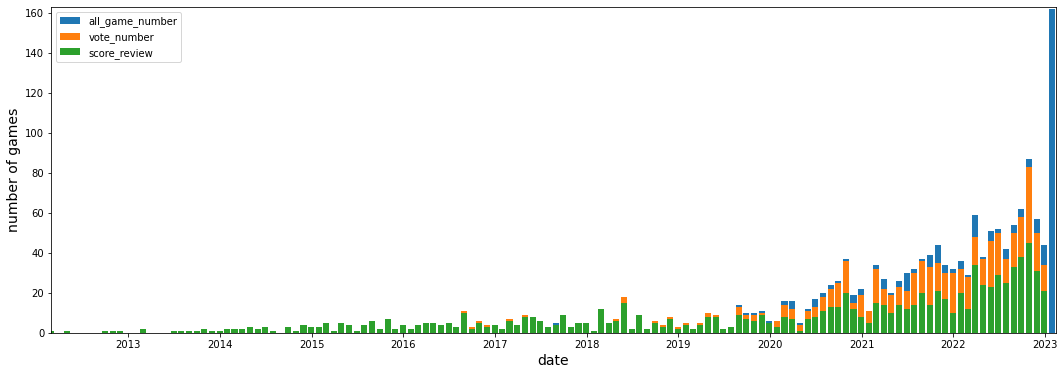

In [19]:
# Build plot
plt.figure(figsize=(18, 6))
y_cap = df_name["n_releases"].max()
plt.xlabel("date", fontsize=14)
plt.ylabel("number of games", fontsize=14)
plt.bar(df_name.index.date, df_name["n_releases"], width=24)
plt.bar(df_vn.index.date, df_vn["n_releases"], width=24)
plt.bar(df_sr.index.date, df_sr["n_releases"], width=24)
plt.legend(['all_game_number', 'vote_number', 'score_review'])
plt.ylim(0, y_cap + 1)
plt.xlim(df_name.index.date[0], df_name.index.date[-1] + datetime.timedelta(days=14))
plt.savefig("sr_vn_distribution.png", dpi=200, bbox_inches='tight')

## 3. Предобработка данных

#### Отберем в отдельную папку JSON файлы, в которых нет пропущенных значений

In [20]:
json_file_names = sorted(glob("jsons_roguelikes/*"))

In [21]:
fields = ["score_review", "name", "release_date", "price", "languages", "dev_genres", "description", "dev_tags"]

In [22]:
# Get all JSON names without missing fields
full_jsons = []
non_missing_data = []
for jname in tqdm(json_file_names):
    game_data = json.load(open(jname, "r"))
    if game_data["is_dlc"]:
        continue
    field_availability = [field in game_data.keys() for field in fields]
    if len(field_availability) == sum(field_availability):
        non_missing_data.append(game_data)
        full_jsons.append(jname)

100%|██████████| 1737/1737 [00:00<00:00, 31804.16it/s]


In [23]:
# Copy full jsons to another folder
for jname in full_jsons:
    short_name = jname.split("/")[-1]
    shutil.copyfile(jname, os.path.join("jsons_full", short_name))

In [24]:
# Preprocess list params
set_genres, set_langs, set_tags = set(), set(), set()
for i in tqdm(range(len(non_missing_data))):
    for genre in non_missing_data[i]["dev_genres"]:
        set_genres.add(genre)
    for lang in non_missing_data[i]["languages"]:
        set_langs.add(lang)
    for tag in non_missing_data[i]["dev_tags"]:
        set_tags.add(tag)

100%|██████████| 928/928 [00:00<00:00, 225353.99it/s]


In [25]:
unique_genres = sorted(list(set_genres))
unique_langs = sorted(list(set_langs))
unique_tags = sorted(list(set_tags))

In [26]:
# Build complex field mappers
genre_mapper = dict(zip(unique_genres, np.arange(len(unique_genres))))
langs_mapper = dict(zip(unique_langs, np.arange(len(unique_langs))))
tags_mapper = dict(zip(unique_tags, np.arange(len(unique_tags))))

##### Разделим выборку на обучение/валидацию

Разделим данные на обучающую и валидационную выборки

In [27]:
def generate_fold(kf, json_names):
    for (train_index, test_index) in kf.split(json_names):
        jsons_train = [json_names[i] for i in train_index]
        jsons_test = [json_names[i] for i in test_index]
        yield jsons_train, jsons_test
kf = KFold(n_splits=4, shuffle=True)

In [28]:
json_file_names_full = sorted(glob("jsons_full/*"))
generator = generate_fold(kf, json_file_names_full)

In [29]:
jsons_train, jsons_test = next(generator)

In [30]:
data_train, data_test = [], []
for jname in jsons_train:
    game_data = json.load(open(jname, "r"))
    data_train.append(game_data)
for jname in jsons_test:
    game_data = json.load(open(jname, "r"))
    data_test.append(game_data)

#### Предобработаем сырые JSON файлы

In [85]:
# Preprocess train data
score_review_train = [int(d["score_review"]) for d in data_train]
names_train = [d["name"] for d in data_train]
names_len_train = [len(d["name"].split()) for d in data_train]
descriptions_train = [d["description"] for d in data_train]
descriptions_len_train = [len(desc.split()) for desc in descriptions_train]
prices_train = [int(d["price"]) for d in data_train]
release_dates_train = [format_date(d["release_date"]) for d in data_train]

genres_train, langs_train, tags_train = [], [], []
for i in tqdm(range(len(data_train))):
    genres_train.append([0] * len(unique_genres))
    langs_train.append([0] * len(unique_langs))
    tags_train.append([0] * len(unique_tags))
    for genre in data_train[i]["dev_genres"]:
        genres_train[i][genre_mapper[genre]] = 1
    for lang in data_train[i]["languages"]:
        langs_train[i][langs_mapper[lang]] = 1
    for tag in data_train[i]["dev_tags"]:
        tags_train[i][tags_mapper[tag]] = 1

100%|██████████| 696/696 [00:00<00:00, 147525.55it/s]


In [86]:
# Preprocess test data
score_review_test = [int(d["score_review"]) for d in data_test]
names_test = [d["name"] for d in data_test]
names_len_test = [len(d["name"].split()) for d in data_train]
descriptions_test = [d["description"] for d in data_test]
descriptions_len_test = [len(desc.split()) for desc in descriptions_test]
prices_test = [int(d["price"]) for d in data_test]
release_dates_test = [format_date(d["release_date"]) for d in data_test]

genres_test, langs_test, tags_test = [], [], []
for i in tqdm(range(len(data_test))):
    genres_test.append([0] * len(unique_genres))
    langs_test.append([0] * len(unique_langs))
    tags_test.append([0] * len(unique_tags))
    for genre in data_test[i]["dev_genres"]:
        genres_test[i][genre_mapper[genre]] = 1
    for lang in data_test[i]["languages"]:
        langs_test[i][langs_mapper[lang]] = 1
    for tag in data_train[i]["dev_tags"]:
        tags_test[i][tags_mapper[tag]] = 1

100%|██████████| 232/232 [00:00<00:00, 128239.13it/s]


Удалим контрольные слова, пунктуацию из описания

In [33]:
# Remove stop words and punctuation from descriptions
stop_words = set(stopwords.words('english'))
new_descr_train, new_descr_test = [], []
for description in descriptions_train:
    description = description.lower()
    description = re.sub(r'[^\d\w\s]', '', description)
    clean_description = ""
    for word in description.split():
        if word not in stop_words:
            clean_description += word + " "
    new_descr_train.append(clean_description[:-1])
for description in descriptions_test:
    description = description.lower()
    description = re.sub(r'[^\d\w\s]', '', description)
    clean_description = ""
    for word in description.split():
        if word not in stop_words:
            clean_description += word + " "
    new_descr_test.append(clean_description[:-1])
descriptions_train = new_descr_train
descriptions_test = new_descr_test

In [34]:
# Count number of words after cleaning description
descriptions_clean_len_train = [len(desc.split()) for desc in descriptions_train]
descriptions_clean_len_test = [len(desc.split()) for desc in descriptions_test]

Обработаем даты

In [35]:
# Transform release date
year_2005 = datetime.date(2005, 1, 1)
releases_dates_train = [(dt - year_2005).days for dt in release_dates_train]
releases_dates_test = [(dt - year_2005).days for dt in release_dates_test]

#### Применим TF-IDF к текстовым данным

Произведем аугментацию описаний игр через синонимичные замены

In [36]:
proba_aug = 0.2
new_descriptions = []
for description in tqdm(descriptions_train):
    new_words = []
    for word in description.split(" "):
        new_word = word
        if np.random.uniform(0, 1) < proba_aug:
            synonyms = wordnet.synsets(word)
            if len(synonyms) > 0:
                synonyms = synonyms[0].lemma_names()
                new_word = synonyms[np.random.randint(0, len(synonyms))]
        new_words.append(new_word)
    new_descriptions.append(" ".join(new_words))

100%|██████████| 696/696 [00:02<00:00, 291.37it/s]


In [37]:
# Preprocess texts with tf-idf
tf_idf_name = TfidfVectorizer(max_features=20)
tf_idf_description = TfidfVectorizer(max_features=300)
tf_idf_name.fit(names_train)
tf_idf_description.fit(descriptions_train + new_descriptions)

names_train = tf_idf_name.transform(names_train).toarray()
names_test = tf_idf_name.transform(names_test).toarray()
descriptions_train = tf_idf_description.transform(descriptions_train).toarray()
new_descriptions = tf_idf_description.transform(new_descriptions).toarray()
descriptions_test = tf_idf_description.transform(descriptions_test).toarray()

#### Построим CNN для изображений и обучим её

In [38]:
# Setup FCN model
class SimpleFCN(torch.nn.Module):
    def __init__(self):
        super(SimpleFCN, self).__init__()
        self.fcn = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(16, 32, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool2d(3),
            torch.nn.Flatten(),
            torch.nn.Linear(576, 200),
            torch.nn.Dropout(0.3),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 50),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 10),
            torch.nn.ReLU()
        )
    
    def forward(self, X):
        return self.fcn(X)
        
class TwoInputCNN(torch.nn.Module):
    def __init__(self):
        super(TwoInputCNN, self).__init__()
        self.fcn_header = SimpleFCN()
        self.fcn_screen = SimpleFCN()
        self.final_linear = torch.nn.Linear(20, 2)

    def forward(self, X_headers, X_screens):
        res_header = self.fcn_header(X_headers)
        res_screen = self.fcn_screen(X_screens)
        conc_res = torch.concat((res_header, res_screen), dim=1)
        return self.final_linear(conc_res)

Простой датасет, возвращающий пару картинок и метку

In [39]:
# Simple dataset for our task
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self , tensors):
        super(CustomDataset, self).__init__()
        self.tensors = tensors

    def __getitem__(self, index):
        X_header = self.tensors[0][index]  
        X_screen = self.tensors[1][index]    
        y = self.tensors[2][index]
        return X_header.to(device), X_screen.to(device), y.to(device)

    def __len__(self):
        return len(self.tensors[0])

Обучение + инициализация + чтение данных

In [40]:
# Main train function
def train_model(model, epochs, optima, crit, train_loader, val_loader):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    confmat = ConfusionMatrix(num_classes=2, task="binary").to(device)
    for i in tqdm(range(epochs)):
        batch_train_losses = []
        batch_train_acc = []
        train_confusion_matrix = torch.zeros((2, 2)).long().to(device)
        for X_header, X_screen, y in train_loader:
            
            optima.zero_grad()
            
            y_pred = model(X_header, X_screen)
            loss = crit(y_pred, y)
            y_act = torch.nn.Sigmoid()(y_pred)
            train_confusion_matrix += confmat(y_act, y)
            batch_train_acc.append(((y_act.argmax(axis=1) == y).sum() / y.shape[0]).item())
            loss.backward()
            batch_train_losses.append(loss.item())
            
            optima.step()
        batch_val_losses = []
        batch_val_acc = []
        val_confusion_matrix = torch.zeros((2, 2)).long().to(device)
        with torch.no_grad():
            for X_header, X_screen, y in val_loader:
                y_pred = model(X_header, X_screen)
                loss = crit(y_pred, y)
                y_act = torch.nn.Sigmoid()(y_pred)
                val_confusion_matrix += confmat(y_act, y)
                batch_val_acc.append(((y_act.argmax(axis=1) == y).sum() / y.shape[0]).item())
                batch_val_losses.append(loss.item())
        train_accuracies.append(np.mean(batch_train_acc))
        train_losses.append(np.mean(batch_train_losses))
        val_accuracies.append(np.mean(batch_val_acc))
        val_losses.append(np.mean(batch_val_losses))
        clear_output()
    return train_losses, val_losses

In [112]:
# Setup model and optimizers
model = TwoInputCNN()
model = model.to(device)

epochs = 100
optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.CrossEntropyLoss()

In [42]:
# Read data and setup it
X_headers_train = []
X_screens_train = []
y_train = np.array(score_review_train) >= config["y_threshold"]
X_headers_test = []
X_screens_test = []
y_test = np.array(score_review_test) >= config["y_threshold"]
for jname in tqdm(jsons_train):
    game_name = jname.split("/")[-1].split(".json")[0]
    header_path = os.path.join("header_images", game_name + ".jpg")
    screen_path = os.path.join("first_screens", game_name + ".jpg")
    header = Image.open(header_path)
    try:
        screen = Image.open(screen_path)
    except FileNotFoundError as e:
        screen = header
    X_headers_train.append(np.array(header.convert("RGB").resize((230, 108))))
    X_screens_train.append(np.array(screen.convert("RGB").resize((300, 169))))
for jname in tqdm(jsons_test):
    game_name = jname.split("/")[-1].split(".json")[0]
    header_path = os.path.join("header_images", game_name + ".jpg")
    screen_path = os.path.join("first_screens", game_name + ".jpg")
    header = Image.open(header_path)
    try:
        screen = Image.open(screen_path)
    except FileNotFoundError as e:
        screen = header
    X_headers_test.append(np.array(header.convert("RGB").resize((203, 108))))
    X_screens_test.append(np.array(screen.convert("RGB").resize((300, 169))))

X_headers_train = np.array(X_headers_train)
X_headers_test = np.array(X_headers_test)
X_screens_train = np.array(X_screens_train)
X_screens_test = np.array(X_screens_test)

100%|██████████| 232/232 [00:01<00:00, 137.69it/s]


In [43]:
# Setup dataset
X_headers_train = torch.from_numpy(X_headers_train).float().permute(0, 3, 1, 2) / 255.
X_screens_train = torch.from_numpy(X_screens_train).float().permute(0, 3, 1, 2) / 255.
X_headers_test = torch.from_numpy(X_headers_test).float().permute(0, 3, 1, 2) / 255.
X_screens_test = torch.from_numpy(X_screens_test).float().permute(0, 3, 1, 2) / 255.
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

In [44]:
train_dataset = CustomDataset((X_headers_train, X_screens_train, y_train))
val_dataset = CustomDataset((X_headers_test, X_screens_test, y_test))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

In [45]:
# train model
_ = train_model(model, 100, optimizer, loss, train_loader, val_loader)
torch.cuda.empty_cache()
gc.collect()

100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


33

In [113]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

299578

Получим метки для этапа 3

In [46]:
# get predictions for catboost
def predict(model, data_loader):
    result = None
    with torch.no_grad():
        for X_header, X_screen, y in data_loader:
            y_pred = model(X_header, X_screen)
            if result is None:
                result = y_pred.to("cpu")
            else:
                result = torch.concat((result, y_pred.to("cpu")))
    return result


train_loader_static = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader_static = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

preds_train = predict(model, train_loader_static)
preds_test = predict(model, val_loader_static)

In [47]:
image_preds_train = preds_train.numpy()
image_preds_test = preds_test.numpy()

#### Построим окончательное векторное представление

In [48]:
# Get smooth or hard label
def get_label(label):
    if not config["do_soft_labels"]:
        return int(label >= config["y_threshold"])
    return 0.5 + (label - config["y_threshold"]) / (1 - config["y_threshold"]) / 2

In [67]:
# Build final samples
X_train, X_test = [], []

for i in range(len(data_train)):
    sample = []
    sample += [get_label(score_review_train[i])]    # y - score-review
    sample += [releases_dates_train[i]]             # release date
    sample += [prices_train[i]]                     # price
    sample += [names_len_train[i]]                  # name length
    sample += [descriptions_len_train[i]]           # num of words in description
    sample += [descriptions_clean_len_train[i]]     # num of words in description without stopwords
    sample += list(image_preds_train[i])            # image outputs
    sample += genres_train[i]                       # list of genres
    sample += tags_train[i]                         # list of tags
    sample += list(names_train[i])                  # game title tf-idf
    sample += langs_train[i]                        # list of languages
    sample += list(descriptions_train[i])           # description tf-idf
    X_train.append(sample)

for i in range(len(data_train)):
    if not config["do_augment"]:
        break
    sample = []
    sample += [get_label(score_review_train[i])]    # y - score-review
    sample += [releases_dates_train[i]]             # release date
    sample += [prices_train[i]]                     # price
    sample += [names_len_train[i]]                  # name length
    sample += [descriptions_len_train[i]]           # num of words in description
    sample += [descriptions_clean_len_train[i]]     # num of words in description without stopwords
    sample += list(image_preds_train[i])            # image outputs
    sample += genres_train[i]                       # list of genres
    sample += tags_train[i]                         # list of tags
    sample += list(names_train[i])                  # game title tf-idf
    sample += langs_train[i]                        # list of languages
    sample += list(new_descriptions[i])             # description tf-idf
    X_train.append(sample)

for i in range(len(data_test)):
    sample = []
    sample += [get_label(score_review_test[i])]
    sample += [releases_dates_test[i]]
    sample += [prices_test[i]]
    sample += [names_len_test[i]]
    sample += [descriptions_len_test[i]]
    sample += [descriptions_clean_len_test[i]]
    sample += list(image_preds_test[i])
    sample += genres_test[i]
    sample += tags_test[i]
    sample += list(names_test[i])
    sample += langs_test[i]
    sample += list(descriptions_test[i])
    X_test.append(sample)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_train.shape, X_test.shape

((696, 474), (232, 474))

In [68]:
len(tags_test[0])

31

In [69]:
# Split vector by X and y
X_train, y_train = X_train[:, 1:], X_train[:, 0]
X_test, y_test = X_test[:, 1:], X_test[:, 0]

In [70]:
X_train.shape, X_test.shape, np.round(y_train.sum() / y_train.shape[0], 2), np.round(y_test.sum() / y_test.shape[0], 2)

((696, 473), (232, 473), 0.52, 0.52)

In [102]:
pca = PCA(2)
res = pca.fit_transform(X_train)
res.shape

(696, 2)

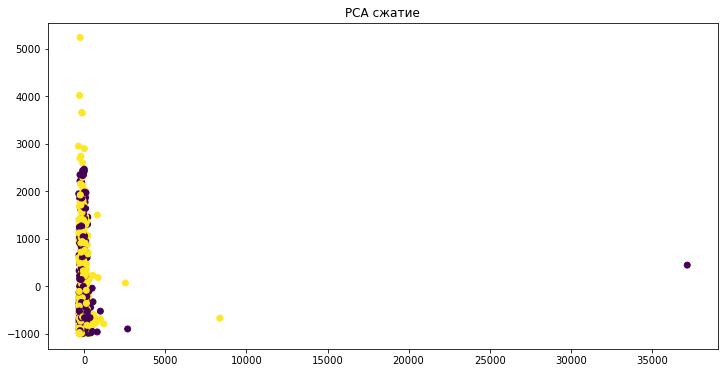

In [108]:
plt.figure(figsize=(12, 6))
plt.scatter(res[:, 0], res[:, 1], c=(y_train >=0.5))
plt.title("PCA сжатие")
plt.savefig("pca.png", dpi=200, bbox_inches='tight')

## 4. Обучение

#### CrossEntropyLoss + catboost

In [71]:
if not config["do_soft_labels"]:
    clf = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=3, loss_function='Logloss')
    clf.fit(X_train, y_train)
    clear_output()
    print((clf.predict(X_train) == y_train).sum() / y_train.shape[0])
    print((clf.predict(X_test) == y_test).sum() / y_test.shape[0])
else:
    clf = CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=5)
    clf.fit(X_train, y_train)
    clear_output()
    print(((clf.predict(X_train) >= 0.5) == (y_train >= 0.5)).sum() / y_train.shape[0])
    print(((clf.predict(X_test) >= 0.5) == (y_test >= 0.5)).sum() / y_test.shape[0])

0.9712643678160919
0.5258620689655172


#### ContrastiveLoss + MLP

Будем использовать простой MLP

In [54]:
# Setup MLP
class SimpleMLP(torch.nn.Module):
    def __init__(self, input_size):
        super(SimpleMLP, self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_size, 300),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),
            torch.nn.Linear(300, 150),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),
            torch.nn.Linear(150, 50),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 20)
        )
    
    def forward(self, X):
        return self.mlp(X)

In [55]:
# Create custom dataset for contrastive loss
class DatasetContrastive(torch.utils.data.Dataset):
    def __init__(self, tensors):
        super(DatasetContrastive, self).__init__()
        self.tensors = tensors

    def __getitem__(self, index):
        X = self.tensors[0][index]   
        y = self.tensors[1][index]  
        index0 = index
        while index0 == index:
            index0 = np.random.randint(len(self.tensors[0]))
        X1 = self.tensors[0][index0]
        y1 = self.tensors[1][index0]
        return X.to(device), X1.to(device), 2 * (y - y1).long().abs().to(device)

    def __len__(self):
        return len(self.tensors[0])

Обучим модель

In [56]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train_tmp = y_train
y_test_tmp = y_test
y_train = torch.from_numpy(y_train >= config["y_threshold"]).long()
y_test = torch.from_numpy(y_test >= config["y_threshold"]).long()

In [57]:
train_dataset = DatasetContrastive((X_train,  y_train))
val_dataset = DatasetContrastive((X_test, y_test))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

In [110]:
# Setup model and optimizers
model = SimpleMLP(X_train.shape[1])
model = model.to(device)

epochs = 100
optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.CosineEmbeddingLoss()

In [59]:
def calc_loss(sim, y):
    return sim * y


def train_model_contrastive_loss(model, epochs, optima, crit, train_loader, val_loader):
    train_losses = []
    val_losses = []
    for i in tqdm(range(epochs)):
        batch_train_losses = []
        batch_train_acc = []
        train_confusion_matrix = torch.zeros((2, 2)).long().to(device)
        for X, X_neg, sim in train_loader:
            
            optima.zero_grad()
            
            embed1 = model(X)
            embed2 = model(X_neg)
            loss = crit(embed1, embed2, 2 * sim - 1)
            loss.backward()
            batch_train_losses.append(loss.item())
            
            optima.step()
    return train_losses, val_losses

In [60]:
_ = train_model_contrastive_loss(model, epochs, optimizer, loss, train_loader, val_loader)

100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Посмотрим на результаты

In [61]:
# get predictions for catboost
def predict(model, data_loader):
    result = None
    with torch.no_grad():
        for X, X_neg, sim in data_loader:
            y_pred = model(X)
            if result is None:
                result = y_pred.to("cpu")
            else:
                result = torch.concat((result, y_pred.to("cpu")))
    return result


train_loader_static = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader_static = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

preds_train = predict(model, train_loader_static)
preds_test = predict(model, val_loader_static)

In [62]:
preds_train = preds_train.numpy()
preds_test = preds_test.numpy()
y_train = y_train_tmp
y_test = y_test_tmp

In [63]:
if not config["do_soft_labels"]:
    knn = KNeighborsClassifier(15)
    knn.fit(X_train, y_train)
    clear_output()
    print((knn.predict(X_train) == y_train).sum() / y_train.shape[0])
    print((knn.predict(X_test) == y_test).sum() / y_test.shape[0])
else:
    knn = KNeighborsRegressor(15)
    knn.fit(X_train, y_train)
    clear_output()
    print(((knn.predict(X_train) >= 0.5) == (y_train >= 0.5)).sum() / y_train.shape[0])
    print(((knn.predict(X_test) >= 0.5) == (y_test >= 0.5)).sum() / y_test.shape[0])

0.5933908045977011
0.5431034482758621
